# Cotton Leaf Disease Classification

In [116]:
'''! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle\ API/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
'''

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
C:\Users\tongc\AppData\Local\Temp\ipykernel_37808\36192093.py:1: SyntaxWarning: invalid escape sequence '\ '
  '''! pip install kaggle


"! pip install kaggle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n! mkdir ~/.kaggle\n!cp /content/drive/MyDrive/Kaggle\\ API/kaggle.json ~/.kaggle/kaggle.json\n! chmod 600 ~/.kaggle/kaggle.json\n"

### 1.0 Imports

In [117]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### 1.1 Kaggle Imports

In [118]:
import kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("seroshkarim/cotton-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\tongc\.cache\kagglehub\datasets\seroshkarim\cotton-leaf-disease-dataset\versions\1


In [119]:
import os
print(os.listdir("Cotton Plant Images"))
path = "Cotton Plant Images"

['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']


### 2. Load Data

In [120]:
transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(350),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # No shuffle for testing

labels_map = {
    0: "bacterial_blight",
    1: "curl_virus",
    2: "fussarium_wilt",
    3: "healthy",
}

image, label = train_dataset[0]
image.size()

torch.Size([3, 350, 350])

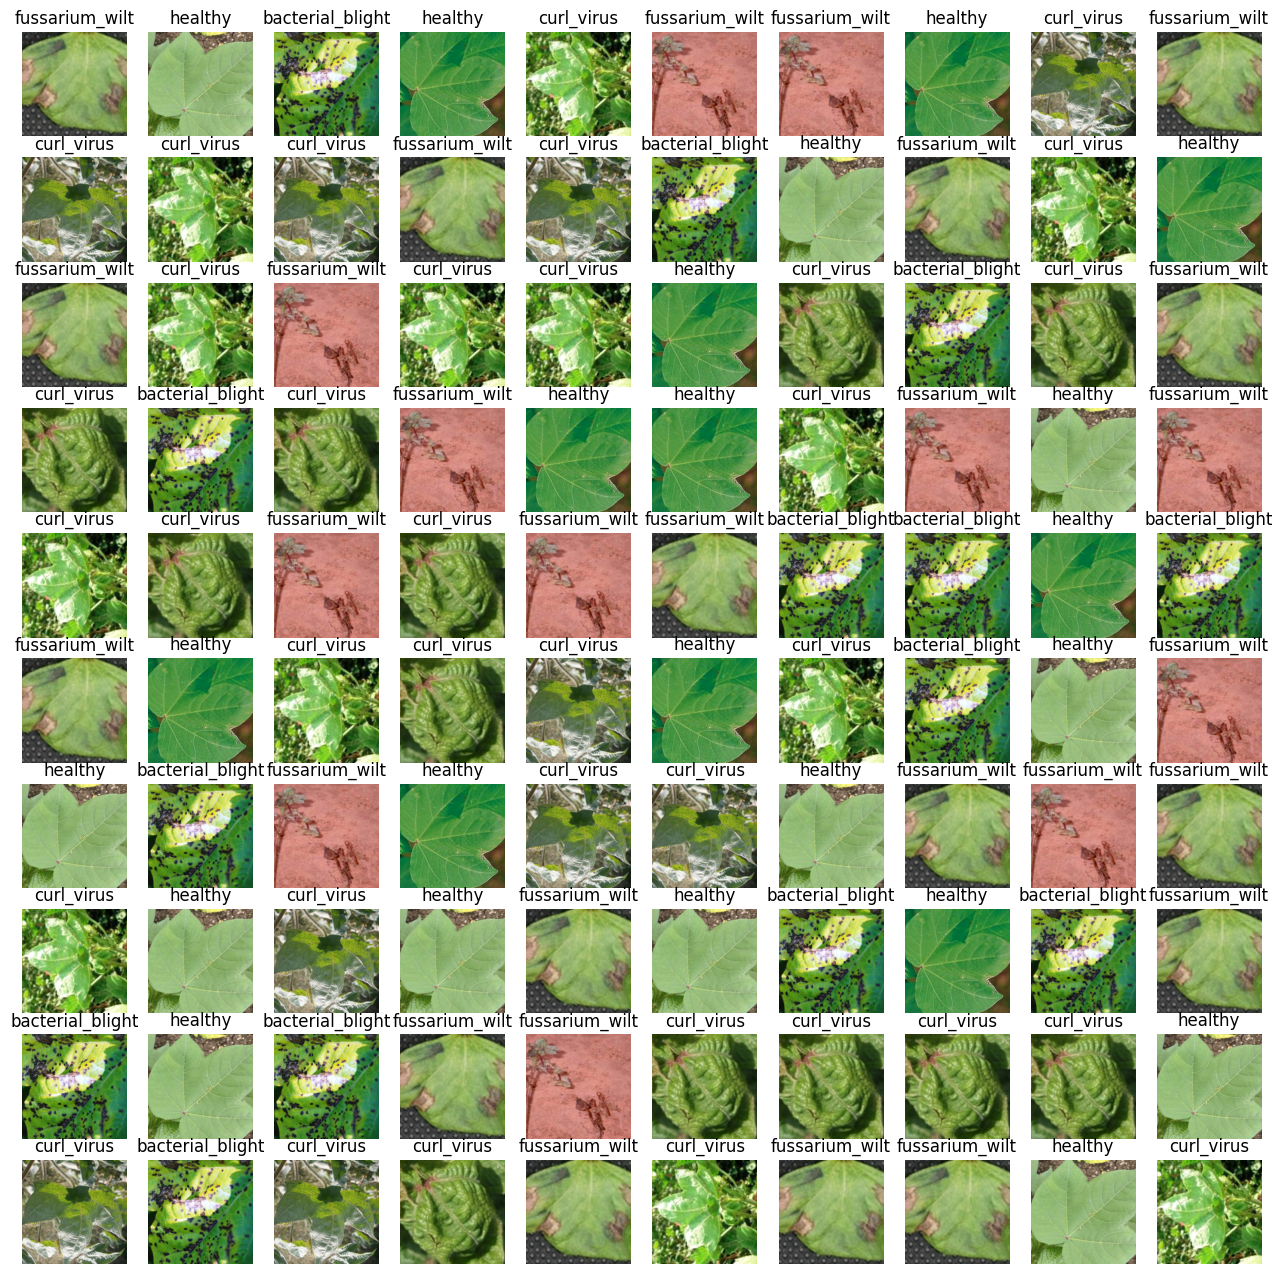

In [121]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display Sample Images
figure = plt.figure(figsize=(16, 16))
cols, rows = 10, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    img = img.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for display
    plt.imshow(img)

plt.show()


### 3. Object Detection Leaf/Plant

In [122]:
# Nats Code



## 4. Image Classification

In [123]:
classnames = ['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']

In [124]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork (nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 7) #(32, 344, 344)
        self.pool = nn.MaxPool2d (2, 2) #(32, 172, 172)
        self.conv2 = nn.Conv2d(32, 64, 7) #(64, 166, 166) #(64, 83, 83)
        self.conv3 = nn.Conv2d (64, 128, 7) # Output: (256, 76, 76) #(128, 38, 38)
        self.conv4 = nn.Conv2d(128, 256, 7) #(256, 32, 32) #(256, 16, 16)

        self.fc1 = nn.Linear(256 * 16 * 16, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [125]:
training_net = NeuralNetwork()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(training_net.parameters(), lr=0.001)

In [126]:
import torch
from tqdm import tqdm

num_epochs = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_net.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    running_loss = 0.0
    for i, data in loop:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = training_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.6f}")

loop.close()


KeyboardInterrupt: 

In [ ]:
test_net = NeuralNetwork()

test_net.load_state_dict(torch.load('trained_network.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_net.to(device)

test_net.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
